# **NHẬP MÔN HỌC MÁY**
## **PHASE 3- RNN**
### Lớp: CQ2022/24
### Thông tin thành viên
|MSSV|Họ và tên|
|-|-|
|22120214| Trương Thị Tú My|
|22120389| Dương Ngọc Kiều Trinh|
|22120422| Nguyễn Phạm Tú Uyên|
#
---

### Import

In [1]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import optuna
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Thiết bị: ưu tiên GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hàm để thiết lập seed để kết quả  mô hình có thể tái lập được
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Đọc dữ liệu

Hàm đọc dữ liệu từ file json

In [4]:
def load_data(json_path, is_train=True):
    '''(str, bool) -> list
    Hàm này đọc dữ liệu từ file json và trả về một list các dictionary.
    
    Mỗi dictionary chứa các thông tin sau:
    - vid_id: id của video
    - start_time: thời gian bắt đầu của clip trong video
    - end_time: thời gian kết thúc của clip trong video
    - audio_embedding: numpy array chứa các đặc trưng âm thanh của clip
    - is_turkey: nhãn cho bài toán phân loại (nếu là train)

    Tham số
    -------
    json_path: đường dẫn đến file json chứa dữ liệu
    is_train: True nếu là dữ liệu train, False nếu là dữ liệu test
    '''
    with open(json_path, 'r') as f:
        data = json.load(f)

    records = []
    for item in data:
        embedding = np.array(item['audio_embedding'])  # (frames, 128)
        record = {
            'vid_id': item['vid_id'],
            'start_time': item['start_time_seconds_youtube_clip'],
            'end_time': item['end_time_seconds_youtube_clip'],
            'audio_embedding': embedding
        }
        if is_train:
            record['is_turkey'] = item['is_turkey']
        records.append(record)
    return records

Đọc dữ liệu từ file json

In [5]:
# Đọc dữ liệu huấn luyện
train_data = load_data('../data/train.json', is_train=True)

### **I. Xây dựng Mô hình**

#### 1. Chuẩn bị dữ liệu

Hàm chuẩn hóa độ dài chuỗi embedding bằng cách cắt hoặc padding về độ dài cố định. 

In [6]:
def extract_sequences_labels(records, max_len=10):
    X, y = [], []
    for r in records:
        emb = np.array(r["audio_embedding"])
        if len(emb) > max_len:
            emb = emb[:max_len]
        elif len(emb) < max_len:
            pad = np.zeros((max_len - len(emb), emb.shape[1]))
            emb = np.vstack([emb, pad])
        X.append(emb)
        if "is_turkey" in r:
            y.append(r["is_turkey"])
    X = np.stack(X)
    y = np.array(y) if y else None
    return X, y

Chia tập train thành 3 phần train, validation và test với tỷ lệ 70:15:15

In [7]:
X, y = extract_sequences_labels(train_data)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (835, 10, 128)
Validation: (180, 10, 128)
Test: (180, 10, 128)


#### 2. Huấn luyện mô hình

Tạo các tập dataset và dataloader cho huấn luyện, kiểm tra và đánh giá mô hình.

In [8]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AudioDataset(X_train, y_train)
valid_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Dataset gộp train + val để dùng huấn luyện mô hình cuối cùng
trainval_dataset = AudioDataset(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Mô hình LSTM kết hợp attention để phân loại âm thanh tiếng gà tây.

In [9]:
class TurkeyClassifierLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, dropout=0.4, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        direction_factor = 2 if bidirectional else 1
        self.attention = nn.Linear(hidden_size * direction_factor, hidden_size)
        self.classifier = nn.Linear(hidden_size * direction_factor, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size * directions)
        attn_scores = torch.tanh(self.attention(lstm_out))
        attn_weights = F.softmax(attn_scores.sum(dim=2), dim=1).unsqueeze(2)
        context = torch.sum(lstm_out * attn_weights, dim=1)
        out = self.classifier(context)
        return out

Early stopping để ngăn overfitting trong quá trình huấn luyện.

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        if self.best_score is None or current_score > self.best_score:
            self.best_score = current_score
            self.counter = 0
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if self.verbose:
                print(f"Improved val score: {self.best_score:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in val score for {self.counter} epochs")
            if self.counter >= self.patience:
                self.early_stop = True

Sử dụng Optuna để tối ưu siêu tham số cho mô hình LSTM với kỹ thuật Stratified K-Fold Cross Validation và Early Stopping.

In [11]:
def objective(trial):
    set_seed(42)
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])

    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    val_auc_scores = []

    train_X_np = X_train
    train_y_np = y_train

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_X_np, train_y_np)):
        fold_train_ds = AudioDataset(train_X_np[train_idx], train_y_np[train_idx])
        fold_val_ds = AudioDataset(train_X_np[val_idx], train_y_np[val_idx])
        fold_train_loader = DataLoader(fold_train_ds, batch_size=batch_size, shuffle=True)
        fold_val_loader = DataLoader(fold_val_ds, batch_size=batch_size)

        model = TurkeyClassifierLSTM(128, hidden_size, num_layers, dropout, bidirectional).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        early_stopping = EarlyStopping(patience=3, verbose=False)

        for _ in range(5):
            model.train()
            train_loss = 0.0
            for xb, yb in fold_train_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0.0
            y_true, y_pred, y_scores = [], [], []
            with torch.no_grad():
                for xb, yb in fold_val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item()

                    probs = torch.softmax(out, dim=1)[:, 1]
                    pred = torch.argmax(out, dim=1)

                    y_true.extend(yb.cpu().numpy())
                    y_pred.extend(pred.cpu().numpy())
                    y_scores.extend(probs.cpu().numpy())

            val_loss /= len(fold_val_loader)
            try:
                val_auc = roc_auc_score(y_true, y_scores)
            except:
                val_auc = 0.0

            early_stopping(val_auc, model)
            if early_stopping.early_stop:
                break

        # Lưu AUC tốt nhất cho fold này
        val_auc_scores.append(early_stopping.best_score or 0.0)

    return sum(val_auc_scores) / len(val_auc_scores)

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

[I 2025-06-07 19:22:38,002] A new study created in memory with name: no-name-f47494ea-b51e-4e9c-83cd-6ba03a62f6bc
[I 2025-06-07 19:23:30,912] Trial 0 finished with value: 0.981100341441171 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.36130858739752336, 'lr': 0.0062948291180786355, 'batch_size': 64, 'bidirectional': True}. Best is trial 0 with value: 0.981100341441171.
[I 2025-06-07 19:24:27,162] Trial 1 finished with value: 0.9818185356956168 and parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.4111037663461382, 'lr': 0.002367395721548993, 'batch_size': 32, 'bidirectional': False}. Best is trial 1 with value: 0.9818185356956168.
[I 2025-06-07 19:24:41,377] Trial 2 finished with value: 0.9707800874178373 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.3310642794047939, 'lr': 0.00023701557977571022, 'batch_size': 32, 'bidirectional': False}. Best is trial 1 with value: 0.9818185356956168.
[I 2025-06-07 19:24:45,625] Trial 3 finished w

Best hyperparameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.2727932084041305, 'lr': 0.0006329093476271122, 'batch_size': 64, 'bidirectional': True}
Best ROC AUC: 0.9892824174479774


Đánh giá các mô hình trên tập train và valid

In [13]:
# Huấn luyện trên train và đánh giá trên valid
best_params = study.best_params
batch_size = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

model = TurkeyClassifierLSTM(
    input_size=128,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    bidirectional=best_params.get("bidirectional", False)  # nếu có
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 30
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Đánh giá trên valid sau mỗi epoch
    model.eval()
    y_true_val, y_scores_val = [], []
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            probs = torch.softmax(out, dim=1)[:, 1]
            y_true_val.extend(yb.cpu().numpy())
            y_scores_val.extend(probs.cpu().numpy())
    val_auc = roc_auc_score(y_true_val, y_scores_val)
    print(f"Epoch {epoch+1}, Validation ROC AUC: {val_auc:.4f}")

    early_stopping(val_auc, model)
    if early_stopping.early_stop:
        print(f"Stopped early at epoch {epoch+1}")
        break

Epoch 1, Validation ROC AUC: 0.9880
Improved val score: 0.9880


Epoch 2, Validation ROC AUC: 0.9807
No improvement in val score for 1 epochs
Epoch 3, Validation ROC AUC: 0.9889
Improved val score: 0.9889
Epoch 4, Validation ROC AUC: 0.9883
No improvement in val score for 1 epochs
Epoch 5, Validation ROC AUC: 0.9857
No improvement in val score for 2 epochs
Epoch 6, Validation ROC AUC: 0.9909
Improved val score: 0.9909
Epoch 7, Validation ROC AUC: 0.9871
No improvement in val score for 1 epochs
Epoch 8, Validation ROC AUC: 0.9847
No improvement in val score for 2 epochs
Epoch 9, Validation ROC AUC: 0.9890
No improvement in val score for 3 epochs
Stopped early at epoch 9


In [14]:
def visualize_evaluation(y_true, y_pred, y_scores, name="Evaluation"):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc_val = auc(fpr, tpr)

    # Classification Report (as dict → DataFrame)
    report = classification_report(y_true, y_pred, target_names=['Non-Turkey', 'Turkey'], output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Remove 'accuracy' row

    # Plotting
    fig = plt.figure(figsize=(18, 5))

    # --- 1. Confusion Matrix ---
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Turkey', 'Turkey'],
                yticklabels=['Non-Turkey', 'Turkey'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # --- 2. Classification Report (Heatmap) ---
    plt.subplot(1, 3, 2)
    sns.heatmap(report_df, annot=True, cmap='Blues', cbar=False, fmt=".2f")
    plt.title('Classification Report Metrics')
    plt.yticks(rotation=0)

    # --- 3. ROC Curve ---
    plt.subplot(1, 3, 3)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
def evaluate_model(model, dataloader, device, name="Validation Set"):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = torch.argmax(out, dim=1)
            
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(f"{name} Classification Report:\n{classification_report(y_true, y_pred)}")

    # Gọi trực quan hóa
    visualize_evaluation(y_true, y_pred, y_scores, name=name)


--- Kết quả đánh giá trên train và valid ---
Train Set Accuracy: 0.8563
Train Set ROC AUC: 0.9936
Train Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       492
           1       0.74      1.00      0.85       343

    accuracy                           0.86       835
   macro avg       0.87      0.88      0.86       835
weighted avg       0.89      0.86      0.86       835



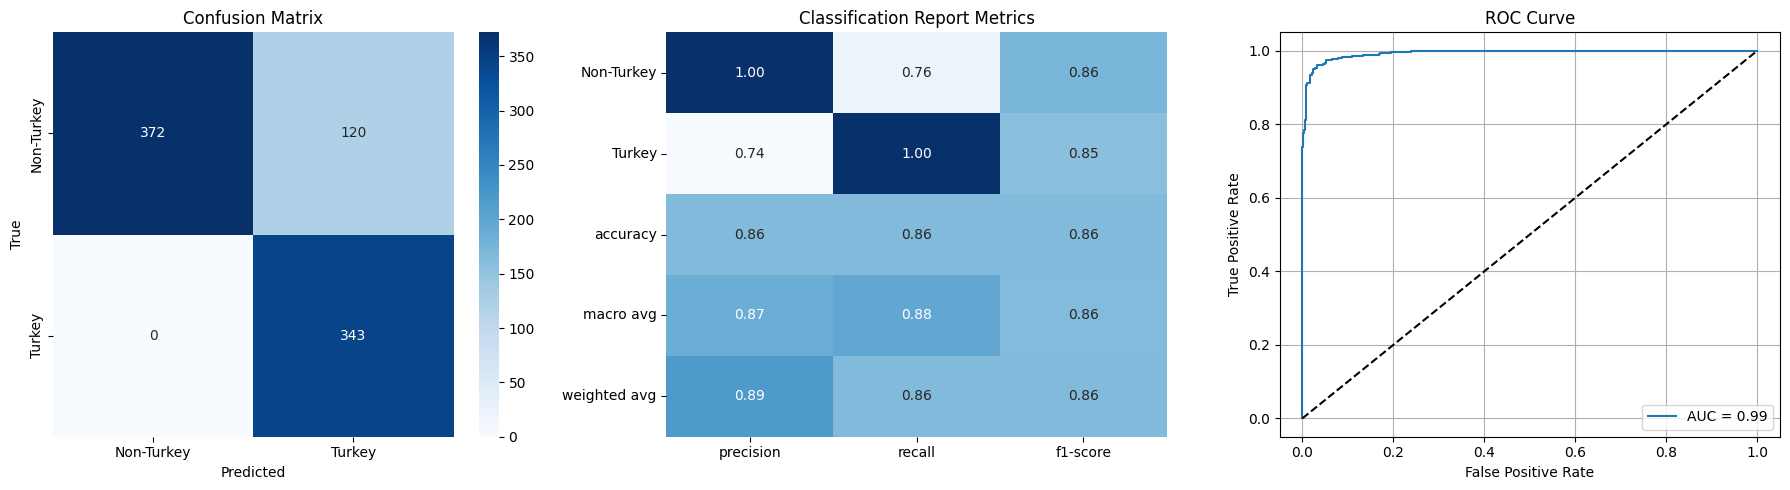

Valid Set Accuracy: 0.8389
Valid Set ROC AUC: 0.9909
Valid Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       106
           1       0.72      0.99      0.83        74

    accuracy                           0.84       180
   macro avg       0.86      0.86      0.84       180
weighted avg       0.88      0.84      0.84       180



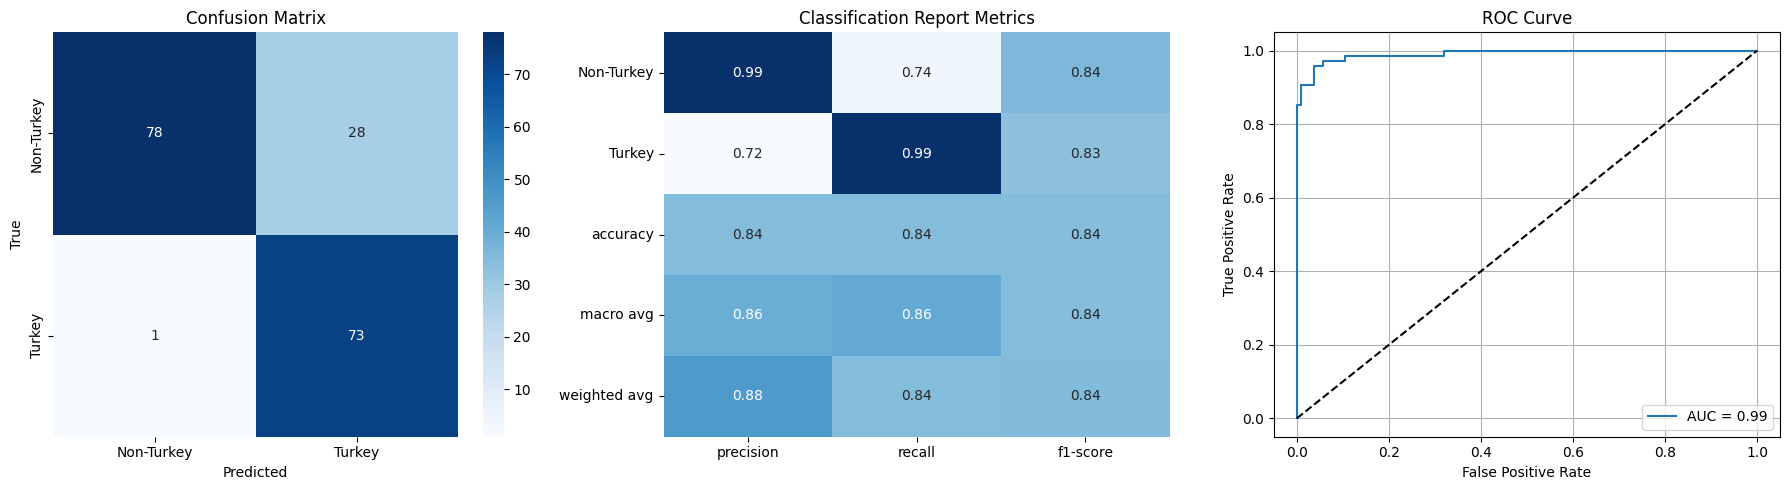

In [15]:
# Load lại mô hình tốt nhất theo EarlyStopping
model.load_state_dict(early_stopping.best_model_state)

print("\n--- Kết quả đánh giá trên train và valid ---")
evaluate_model(model, train_loader, device, name="Train Set")
evaluate_model(model, valid_loader, device, name="Valid Set")

Huấn luyện mô hình cuối cùng với siêu tham số tốt nhất và áp dụng Early Stopping trên tập train + validation.

In [16]:
# Huấn luyện lại trên toàn bộ train + valid
train_valid_dataset = ConcatDataset([train_dataset, valid_dataset])
train_valid_loader = DataLoader(train_valid_dataset, batch_size=batch_size, shuffle=True)

model_full = TurkeyClassifierLSTM(
    input_size=128,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    bidirectional=best_params.get("bidirectional", False)
).to(device)

optimizer_full = torch.optim.Adam(model_full.parameters(), lr=best_params["lr"])
criterion_full = torch.nn.CrossEntropyLoss()

num_epochs_full = 30
early_stopping_full = EarlyStopping(patience=3, verbose=True)

for epoch in range(num_epochs_full):
    model_full.train()
    for xb, yb in train_valid_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model_full(xb)
        loss = criterion_full(preds, yb)
        optimizer_full.zero_grad()
        loss.backward()
        optimizer_full.step()

    # Đánh giá trên toàn bộ tập train+valid sau mỗi epoch
    model_full.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for xb, yb in train_valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model_full(xb)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            y_true.extend(yb.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except:
        roc_auc = 0.0

    print(f"Epoch {epoch+1}/{num_epochs_full} - Train+Valid ROC AUC: {roc_auc:.4f}")

    # Early stopping
    early_stopping_full(roc_auc, model_full)
    if early_stopping_full.early_stop:
        print(f"Stopped early at epoch {epoch+1}")
        break

Epoch 1/30 - Train+Valid ROC AUC: 0.9888
Improved val score: 0.9888
Epoch 2/30 - Train+Valid ROC AUC: 0.9905
Improved val score: 0.9905
Epoch 3/30 - Train+Valid ROC AUC: 0.9918
Improved val score: 0.9918
Epoch 4/30 - Train+Valid ROC AUC: 0.9946
Improved val score: 0.9946
Epoch 5/30 - Train+Valid ROC AUC: 0.9952
Improved val score: 0.9952
Epoch 6/30 - Train+Valid ROC AUC: 0.9947
No improvement in val score for 1 epochs
Epoch 7/30 - Train+Valid ROC AUC: 0.9926
No improvement in val score for 2 epochs
Epoch 8/30 - Train+Valid ROC AUC: 0.9939
No improvement in val score for 3 epochs
Stopped early at epoch 8


### **II. Đánh giá mô hình**

Dự đoán trên tập test và đánh giá mô hình


--- Kết quả đánh giá trên test có nhãn ---
Test Labeled Set Accuracy: 0.9222
Test Labeled Set ROC AUC: 0.9927
Test Labeled Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       106
           1       1.00      0.81      0.90        74

    accuracy                           0.92       180
   macro avg       0.94      0.91      0.92       180
weighted avg       0.93      0.92      0.92       180



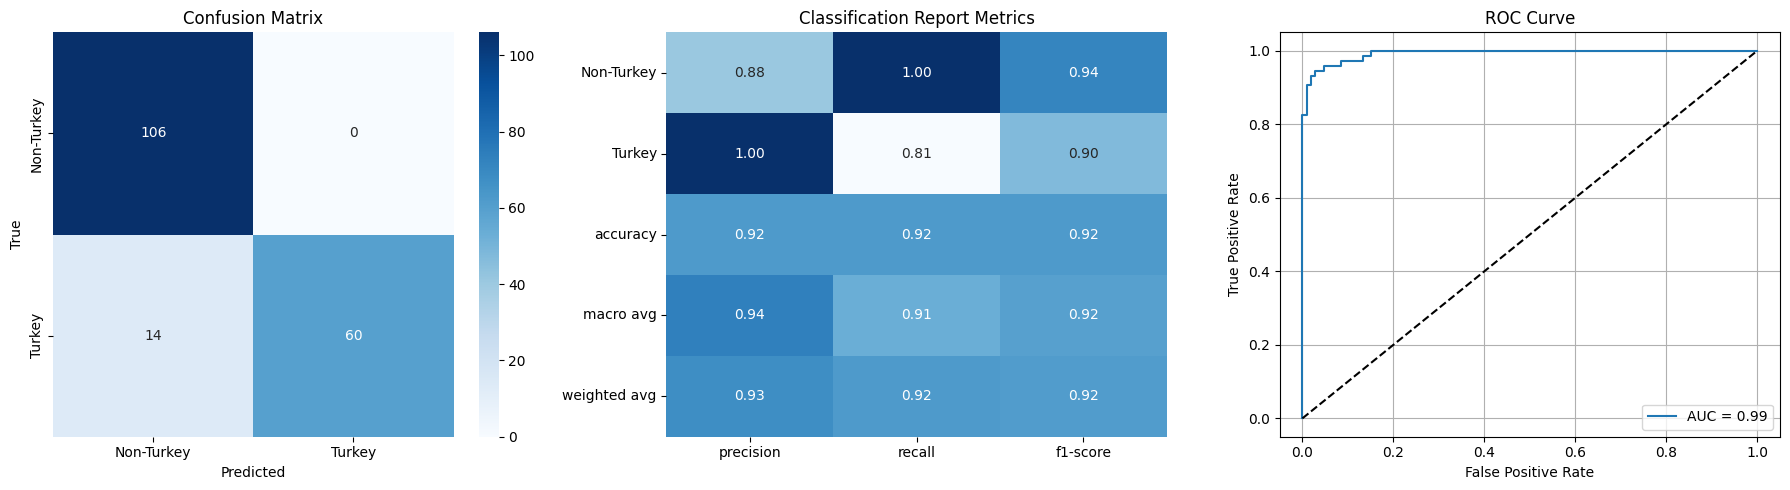

In [17]:
# Đánh giá trên test có nhãn
print("\n--- Kết quả đánh giá trên test có nhãn ---")
evaluate_model(model_full, test_loader, device, name="Test Labeled Set")

### Dự đoán kết quả của tập test ẩn

Ta dự đoán kết quả của tập test ẩn và lưu lại.

In [18]:
test_data = load_data('../data/test.json', is_train=False)

X_test_hidden, _ = extract_sequences_labels(test_data)

test_tensor = torch.tensor(X_test_hidden, dtype=torch.float32)
test_dataset = torch.utils.data.TensorDataset(test_tensor)  # vì không có label
test_loader = DataLoader(test_dataset, batch_size=32)

model_full.eval()
test_probs = []
vid_ids = [r['vid_id'] for r in test_data]

with torch.no_grad():
    for (x_batch,) in test_loader:  # unpack 1 phần tử tuple
        x_batch = x_batch.to(device)
        outputs = model_full(x_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # lấy xác suất lớp 1
        test_probs.extend(probs.cpu().numpy())

submission_df = pd.DataFrame({
    'vid_id': vid_ids,
    'is_turkey': test_probs
})
submission_df.to_csv('result_rnn.csv', index=False)

print("Đã lưu kết quả dự đoán vào 'result_rnn.csv'")

Đã lưu kết quả dự đoán vào 'result_rnn.csv'
